# Loan Prediction

in this project, a machine learning model would develop a model for predicting wether a person can recieve a bank loan or not. I will be using pytorch's framework for this project.

## Import Needed Libraries

In [1]:
! pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=50198f799027d8ecd6df6a3620949bad70b31a8c9d478e647e72223213c4741e
  Stored in directory: /root/.cache/pip/wheels/5e/90/99/807a5ad861ce5d22c3c299a11df8cba9f31524f23ae6e645cb
Successfully built autocorrect


In [2]:
# Basic Python Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import os
import pickle

# for text correction
from autocorrect import Speller

# preprocessing libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV

# ML Libraries
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# for cleaner notebook
from tqdm import tqdm

## EDA

In [3]:
#import the data
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/Loan_prediction_project/Datset/loan.csv")

Mounted at /content/drive


In [4]:

data.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   42750 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [6]:
is_na = pd.DataFrame(data.isna().sum())
is_na.columns = ['missing_count']
is_na['missing_percent'] = is_na['missing_count'] / len(data) * 100
is_na

,missing_count,missing_percent
person_age,0,0.0
person_gender,0,0.0
person_education,0,0.0
person_income,2250,5.0
person_emp_exp,0,0.0
person_home_ownership,0,0.0
loan_amnt,0,0.0
loan_intent,0,0.0
loan_int_rate,0,0.0
loan_percent_income,0,0.0


Turns out there are 2250 of the person income data that is missing. Therefore we need to inspect if it just needs to be deleted or filled with average or median of the data.

### Plotting functions

In [7]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

In [8]:
#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data.

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")

    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")

    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization for Each Numeric Column", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

In [9]:
#function for plotting categorical data distribution
def categoric_dist_plot(data: pd.DataFrame):
    """_summary_

    Args:
        data (pd.DataFrame): Categorical pandas dataframe

    Raises:
        TypeError: The following columns are not categorical: {non_numeric_cols}
        This is due to some of the columns are not categorical.

    Returns:
        plt: Plot of the categorical data distribution
    """
    # Checks
    ## Check if all columns are numeric
    non_categoric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
    if non_categoric_cols:
        raise TypeError(f"The following columns are not categoric: {non_categoric_cols}")

    # Create subplots: one row for each categorical column
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(10, num_rows * 3), sharex=False)

    # Flatten axes for easier handling if there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    # Plot each categorical distribution
    for i, col in enumerate(data.columns):
        counts = data[col].value_counts(dropna=False)  # Get the count values
        counts.index = counts.index.astype(str) #convert the categorical values to strings since there are numerical categories

        #Create the bar plot
        axes[i].bar(counts.index, counts)

        # Set title and labels
        axes[i].set_title(f"Distribution of {col}", fontsize=12)
        axes[i].set_ylabel("Count")
        axes[i].set_xlabel("Category")

        # Rotate x-axis labels for better readability
        axes[i].tick_params(axis='x', rotation=90)

    # Add an overall title and adjust layout
    fig.suptitle("Bar Plots for Categorical Columns", fontsize=16, y=1.02)
    fig.tight_layout(h_pad=2.0)  # Adjust spacing between rows
    return plt

### Split data to categorical and numerical

In [10]:
categorical_data = data.select_dtypes(exclude=[np.number])
numerical_data = data.select_dtypes(include=[np.number])

### Plotting

#### numerical data distribution

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

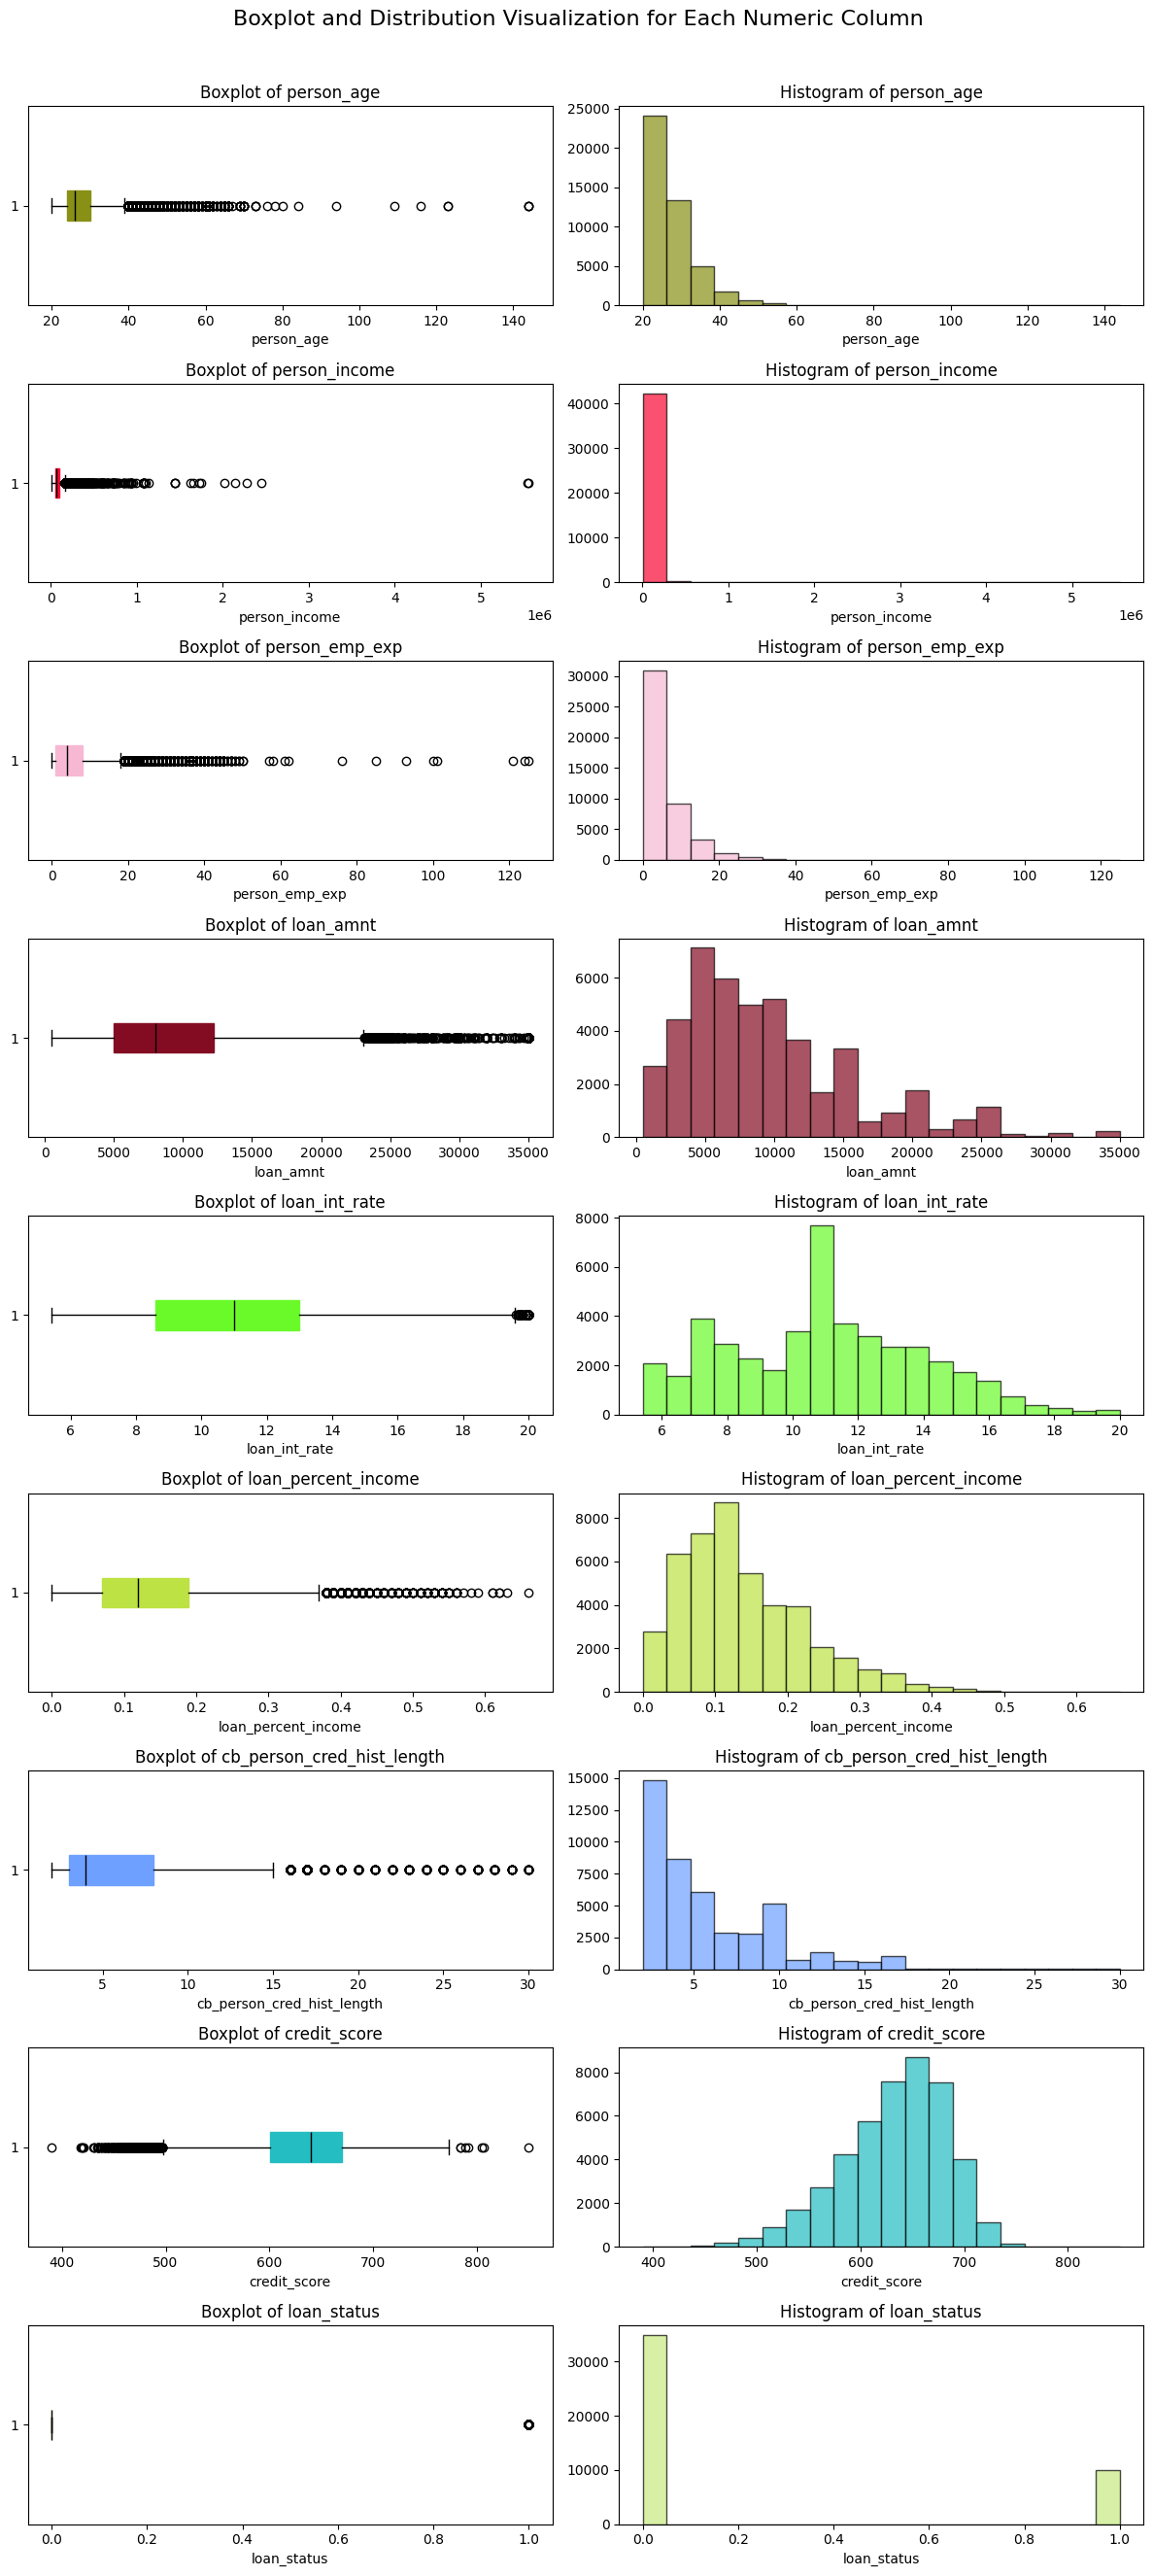

In [11]:
numeric_dist_plot(numerical_data)

#### Categorical data distribution

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

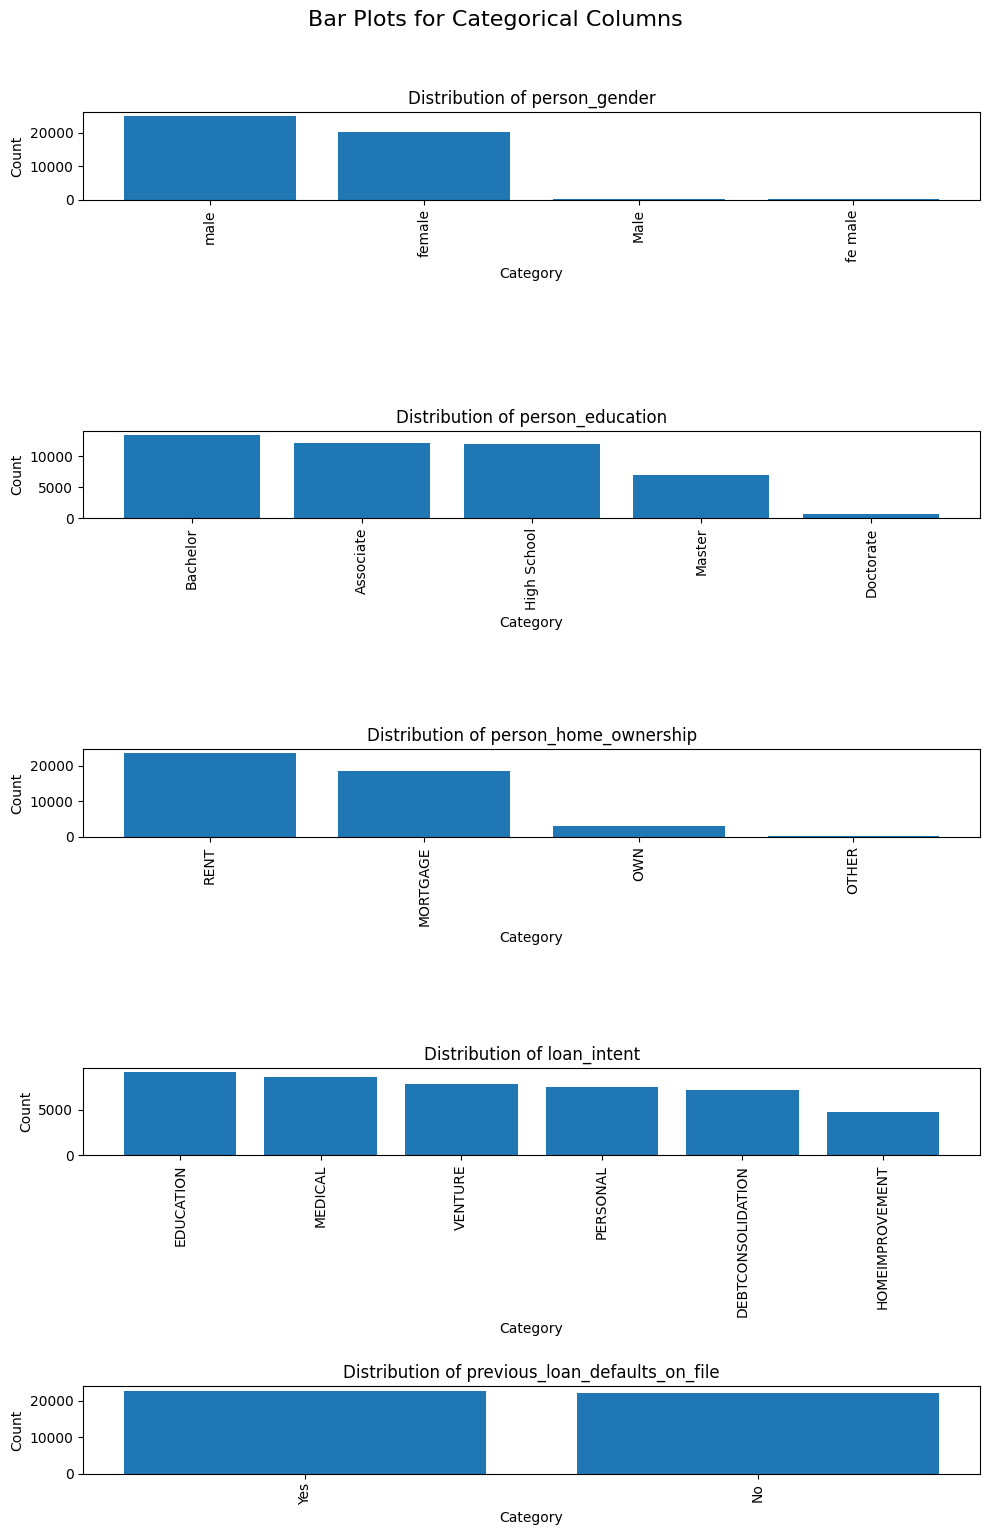

In [12]:
categoric_dist_plot(categorical_data)

## Data Cleaning

### Fix the gender inconsistency

#### function to standardize the genders values

In [13]:
def str_corrector(text: str):

    if not isinstance(text, str):
        raise ValueError("Input must be a string")

    # standardize the text to lowercase and strip additional empty spaces
    text = text.lower().strip()

    #correvt the text using the autocorrect library
    corrector = Speller(lang='en')
    corrected_text = corrector(text)

    return corrected_text

In [14]:
def save_cache(data, path):
    """This is a function to save the data to a file using pickle

    Args:
        data (_type_): data to be saved
        path : "path/to/file.txt"
    """

    pickle_out = open(path,"wb")
    pickle.dump(data, pickle_out)
    pickle_out.close()

    print(f"Data saved to {path}")

def load_cache(path):
    """This is a function to load the data to a file using pickle

    Args:
        data (_type_): data to be saved
        filename (_type_): the name of the file to load the data to
    """
    with open(path, 'rb') as f:
      print(f"Data loaded from {path}")
      return pickle.load(f)

In [15]:
pickle_path = "/content/drive/MyDrive/Loan_prediction_project/Pickle_object/"
cache_file_path = os.path.join(pickle_path, "cached_dataset.pkl")

if os.path.exists(cache_file_path):
    print("Loading cached dataset...")
    dataset = load_cache(cache_file_path)
else:
    #this enables the progress bar for the text correction
    tqdm.pandas(desc="Correcting Text")
    data["person_gender"] = tqdm(data["person_gender"].progress_apply(str_corrector))
    save_cache(data, "cached_dataset.pkl")


100%|██████████| 45000/45000 [00:00<00:00, 2133347.80it/s]

Data saved to cached_dataset.pkl


In [16]:
#check the data again
data.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


### Fix missing values

As previously seen in the EDA, there are 2250 number of data that is missing in the `person_income` column. even though it is 5% of the data, it is

In [17]:
data_missing = (data[data.isna().any(axis=1)])
len(data_missing)

2250

In [18]:
data["person_income"] = data["person_income"].fillna(data["person_income"].mean())

## Preprocessing
for preprocessing the data, we just need to encode the data and no need to scale the data. Due to this is a tree based algorithm, it is robust towards outliers and no need scaling.

### Train test split

In [19]:
x = data.drop(columns=["loan_status"])
y = data["loan_status"]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)

In [20]:
len(train_y), len(train_x)

(36000, 36000)

### Encoding the data

In [21]:
gender_enc =  LabelEncoder()
education_enc = OrdinalEncoder(categories=[['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']], handle_unknown="use_encoded_value", unknown_value=-1).set_output(transform="pandas") # education would be encoded as ordinal data since there is a hierarical relationship between the categories
home_ownership_enc = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
loan_intent_enc = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
previous_loans_enc = LabelEncoder()


In [22]:
train_x["person_education"].unique()

array(['Bachelor', 'High School', 'Master', 'Associate', 'Doctorate'],
      dtype=object)

In [23]:
train_x.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file'],
      dtype='object')

### Apply the encoder

#### Apply to train data

In [24]:
# encoding the categorical variables
train_gender_encoded = pd.DataFrame(gender_enc.fit_transform(train_x["person_gender"]))
train_gender_encoded.columns = ["gender"]

train_home_ownership_encoded = pd.DataFrame(home_ownership_enc.fit_transform(train_x[["person_home_ownership"]]))
train_home_ownership_encoded.columns = home_ownership_enc.get_feature_names_out(["person_home_ownership"])

train_loan_intent_encoded = loan_intent_enc.fit_transform(train_x[["loan_intent"]])
train_loan_intent_encoded.columns = loan_intent_enc.get_feature_names_out(["loan_intent"])

train_prev_loans_encoded = pd.DataFrame(previous_loans_enc.fit_transform(train_x["previous_loan_defaults_on_file"]))
train_prev_loans_encoded.columns = ['previous_loan_default']

train_education_encoded = pd.DataFrame(education_enc.fit_transform(train_x[["person_education"]]))
train_education_encoded.columns = ['education_level']

In [25]:
len(train_gender_encoded), len(train_home_ownership_encoded), len(train_loan_intent_encoded), len(train_prev_loans_encoded), len(train_education_encoded)

(36000, 36000, 36000, 36000, 36000)

In [26]:
#combine all the data and drop the original columns
train_x = pd.concat([train_x.drop(columns=["person_gender", "person_home_ownership", "loan_intent", "previous_loan_defaults_on_file", "person_education"]).reset_index(drop=True),
                     train_gender_encoded.reset_index(drop=True),
                     train_home_ownership_encoded.reset_index(drop=True),
                     train_loan_intent_encoded.reset_index(drop=True),
                     train_prev_loans_encoded.reset_index(drop=True),
                     train_education_encoded.reset_index(drop=True)], axis=1)

In [27]:
train_x

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,gender,person_home_ownership_MORTGAGE,...,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_default,education_level
0,34.0,97265.000000,11,15000.0,12.73,0.15,9.0,631,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,2.0
1,25.0,80182.226222,3,12000.0,11.86,0.16,4.0,659,2,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0
2,41.0,322597.000000,18,24000.0,10.37,0.07,11.0,683,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,3.0
3,27.0,94232.000000,4,9600.0,17.14,0.10,7.0,641,2,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1.0
4,27.0,80182.226222,7,7059.0,12.97,0.08,3.0,706,2,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,26.0,80182.226222,6,10625.0,6.03,0.12,4.0,559,2,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0.0
35996,25.0,34772.000000,3,5876.0,11.69,0.17,4.0,647,1,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0
35997,33.0,58317.000000,9,10707.0,10.74,0.18,9.0,652,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0
35998,26.0,178602.000000,6,20000.0,17.99,0.11,3.0,604,2,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,3.0


In [28]:
len(train_y), len(train_x)

(36000, 36000)

#### Apply to test data

In [29]:
#transform the test data
test_gender_encoded = pd.DataFrame(gender_enc.transform(test_x["person_gender"]))
test_home_ownership_encoded = pd.DataFrame(home_ownership_enc.transform(test_x[["person_home_ownership"]]))
test_loan_intent_encoded = loan_intent_enc.transform(test_x[["loan_intent"]])
test_prev_loans_encoded = pd.DataFrame(previous_loans_enc.transform(test_x["previous_loan_defaults_on_file"]))
test_education_encoded = pd.DataFrame(education_enc.transform(test_x[["person_education"]]))

In [30]:
#combine all the data and drop the original columns
test_x = pd.concat([test_x.drop(columns=["person_gender", "person_home_ownership", "loan_intent", "previous_loan_defaults_on_file", "person_education"]),
                     test_gender_encoded,
                     test_home_ownership_encoded,
                     test_loan_intent_encoded,
                     test_prev_loans_encoded,
                     test_education_encoded], axis=1)

## Model Training

### Random forest model

In [31]:
#Grid search setup
rf_grid = RandomForestClassifier()
gr_space = {
    "n_estimators": [100, 200, 300],  # number of trees
    "max_depth": [None, 10, 20, 30],  # tree depth
    "min_samples_split": [2, 5, 10],  # min samples to split a node
    "min_samples_leaf": [1, 2, 4],    # min samples at leaf
    "max_features": ['auto', 'sqrt', 'log2'],  # features considered at each split
    "bootstrap": [True, False],       # whether bootstrap samples are used
    "class_weight": [None, 'balanced'],  # helpful if your classes are imbalanced
}

rf_model_grid = GridSearchCV(rf_grid,
                             gr_space,
                             cv = 3,
                             scoring='f1_macro',
                             verbose = 3,
                             n_jobs=-1 #all cores
                             )

In [32]:
#flatten the y_train
train_y = train_y.values.ravel()

In [34]:
rf_model_result = rf_model_grid.fit(train_x, train_y)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1296 fits failed out of a total of 3888.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
645 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py

In [35]:
rf_best_params = rf_model_result.best_params_
print("Grid search result for optimal parameters: ")
for param in sorted(rf_best_params.keys()):
    print(f"{param}: {rf_best_params[param]}")

Grid search result for optimal parameters: 
bootstrap: False
class_weight: balanced
max_depth: None
max_features: log2
min_samples_leaf: 2
min_samples_split: 2
n_estimators: 100


### XGBoost Classifier Model

In [36]:
#Grid search setup
xgb_grid = XGBClassifier()
xgb_grid_space = {
    "n_estimators": [100, 200, 300],           # Number of trees
    "max_depth": [3, 5, 7, 10],                # Max depth of a tree
    "learning_rate": [0.01, 0.1, 0.2, 0.3],    # Step size shrinkage
    "subsample": [0.6, 0.8, 1.0],              # Fraction of rows to use per tree
    "colsample_bytree": [0.6, 0.8, 1.0],       # Fraction of columns to use per tree
    "gamma": [0, 1, 5],                        # Minimum loss reduction required to split
    "reg_alpha": [0, 0.1, 1],                  # L1 regularization
    "reg_lambda": [1, 5, 10],                  # L2 regularization
    "scale_pos_weight": [1, 2, 5],             # To balance positive/negative weights
}


xgb_model_grid = GridSearchCV(xgb_grid,
                             xgb_grid_space,
                             cv = 3,
                             scoring='f1_macro',
                             verbose = 3,
                             n_jobs=-1 #all cores
                             )

In [37]:
xgb_model_result = xgb_model_grid.fit(train_x, train_y)

Fitting 3 folds for each of 34992 candidates, totalling 104976 fits


In [38]:
xgb_best_params = xgb_model_result.best_params_
print("Grid search result for optimal parameters: ")
for param in sorted(xgb_best_params.keys()):
    print(f"{param}: {xgb_best_params[param]}")

Grid search result for optimal parameters: 
colsample_bytree: 0.8
gamma: 0
learning_rate: 0.1
max_depth: 5
n_estimators: 300
reg_alpha: 0
reg_lambda: 1
scale_pos_weight: 1
subsample: 0.8
